## **Feature Importance** 

In [26]:
#importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

### Data Preparation

In [27]:
# loading the dataset

data = pd.read_csv("data/patient_data.csv")
data.dtypes

Patient               int64
Hospital             object
Age                 float64
Sex                  object
ROSC                float64
OHCA                 object
Shockable Rhythm     object
TTM                 float64
Outcome              object
CPC                   int64
dtype: object

In [28]:
# Assigning data types
# Explicitly convert the nominal categorical variables, that were objects before
data['Hospital'] = data['Hospital'].astype("category")
data['Sex'] = data['Sex'].astype("category")
data['OHCA'] = data['OHCA'].astype("category")
data['Shockable Rhythm'] = data['Shockable Rhythm'].astype("category")
data['Outcome'] = data['Outcome'].astype("category")

# Replace the column names and store it in the same variable name
data = data.rename(columns={
                            "Hospital": "hospital",
                            "Age": "age",
                            "Sex": "sex",
                            "ROSC": "rosc",
                            "OHCA": "ohca",
                            "Shockable Rhythm": "shockable_rhythm",
                            "TTM": "ttm",
                            "Outcome": "outcome", 
                            "CPC": "cpc"
                            })

# Remove the Patient column as it does not contain relevant information right now (unless eeg and ecg data is used later)
data.drop("Patient", axis=1, inplace=True)

data.head()

,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc
0,A,53.0,Male,NaN,True,True,33.0,Good,1
1,F,85.0,Female,7.0,False,False,NaN,Good,1
2,A,48.0,Male,NaN,True,True,36.0,Good,1
3,A,45.0,Male,NaN,True,True,33.0,Good,1
4,D,51.0,Male,24.0,True,True,33.0,Good,1


In [29]:
# handling missing values
# 1. For 'age' (numeric columns), impute with mean
data['age'].fillna(data['age'].mean(), inplace=True)

# 2. For categorical variables 'sex', impute with the mode
data['sex'].fillna(data['sex'].mode()[0], inplace=True)

# 3. Create binary flag columns to indicate missing values for 'rosc' and 'shockable_rhythm'
data['rosc_missing'] = data['rosc'].isnull().astype(int)
data['shockable_rhythm_missing'] = data['shockable_rhythm'].isnull().astype(int)

# 4. Impute with a placeholder value -1
data['rosc'].fillna(-1, inplace=True)

# 5. Add a new category for 'shockable_rhythm'
data['shockable_rhythm'] = data['shockable_rhythm'].cat.add_categories('Unknown')
data['shockable_rhythm'].fillna('Unknown', inplace=True)

# 6. Add a new category for 'ohca'
data['ohca'] = data['ohca'].astype('category')
data['ohca'] = data['ohca'].cat.add_categories('Unknown')
data['ohca'].fillna('Unknown', inplace=True)

# 7. Change 'ttm' to categorical and add a ew category
data['ttm'] = data['ttm'].astype('category')
data['ttm'] = data['ttm'].cat.add_categories('No TTM')
data['ttm'].fillna('No TTM', inplace=True)

# Count missing values per feature again
data.isnull().sum()

C:\Users\munas\AppData\Local\Temp\ipykernel_6852\3549640891.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].mean(), inplace=True)
C:\Users\munas\AppData\Local\Temp\ipykernel_6852\3549640891.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

hospital                    0
age                         0
sex                         0
rosc                        0
ohca                        0
shockable_rhythm            0
ttm                         0
outcome                     0
cpc                         0
rosc_missing                0
shockable_rhythm_missing    0
dtype: int64

In [30]:
# checking unique categories of categorical columns
cat_col = ['hospital', 'sex', 'ohca', 'ttm', 'shockable_rhythm']

for col in cat_col:
    unique_values = data[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'hospital': ['A', 'F', 'D', 'E', 'B']
Categories (5, object): ['A', 'B', 'D', 'E', 'F']
Unique values in 'sex': ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Unique values in 'ohca': [True, False, 'Unknown']
Categories (3, object): [False, True, 'Unknown']
Unique values in 'ttm': [33.0, 'No TTM', 36.0]
Categories (3, object): [33.0, 36.0, 'No TTM']
Unique values in 'shockable_rhythm': [True, False, 'Unknown']
Categories (3, object): [False, True, 'Unknown']


In [31]:
# one-hot encoding of categorical variables
oh_cat_col = pd.get_dummies(data[cat_col])
oh_cat_col

,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,False,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False
603,False,False,False,False,True,False,True,False,True,False,False,False,True,True,False,False
604,False,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False
605,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False


In [32]:
# Concatenating the one-hot encoded dataframe with the numerical one 

numerical_col = ['age', 'rosc' ]


data_encoded = pd.concat([data[numerical_col], oh_cat_col], axis=1)

data_encoded



,age,rosc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,53.0,-1.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,85.0,7.0,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,48.0,-1.0,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,45.0,-1.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,51.0,24.0,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,87.0,7.0,False,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False
603,26.0,52.0,False,False,False,False,True,False,True,False,True,False,False,False,True,True,False,False
604,63.0,-1.0,False,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False
605,72.0,-1.0,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False


## Feature Selection by Mutual Information

In [33]:
# Feature selection by Mutual Information 

# mapping the target variable
data['outcome'] = data['outcome'].map({
    "Poor": 0,
    "Good": 1
})

# retrieving numpy arrays
X = data_encoded.values
y = data['outcome'].values

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify= y, random_state=42)

# feature selection 
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 0.056709
Feature 1: 0.000000
Feature 2: 0.036565
Feature 3: 0.017905
Feature 4: 0.000000
Feature 5: 0.000000
Feature 6: 0.006044
Feature 7: 0.000814
Feature 8: 0.000000
Feature 9: 0.000000
Feature 10: 0.016234
Feature 11: 0.000000
Feature 12: 0.000000
Feature 13: 0.029493
Feature 14: 0.000000
Feature 15: 0.057199
Feature 16: 0.107494
Feature 17: 0.032246


Feature: shockable_rhythm_True, Score: 0.107494
Feature: shockable_rhythm_False, Score: 0.057199
Feature: age, Score: 0.056709
Feature: hospital_A, Score: 0.036565
Feature: shockable_rhythm_Unknown, Score: 0.032246
Feature: ttm_36.0, Score: 0.029493
Feature: hospital_B, Score: 0.017905
Feature: ohca_True, Score: 0.016234
Feature: hospital_F, Score: 0.006044
Feature: sex_Female, Score: 0.000814
Feature: rosc, Score: 0.000000
Feature: hospital_D, Score: 0.000000
Feature: hospital_E, Score: 0.000000
Feature: sex_Male, Score: 0.000000
Feature: ohca_False, Score: 0.000000
Feature: ohca_Unknown, Score: 0.000000
Feature: ttm_33.0, Score: 0.000000
Feature: ttm_No TTM, Score: 0.000000


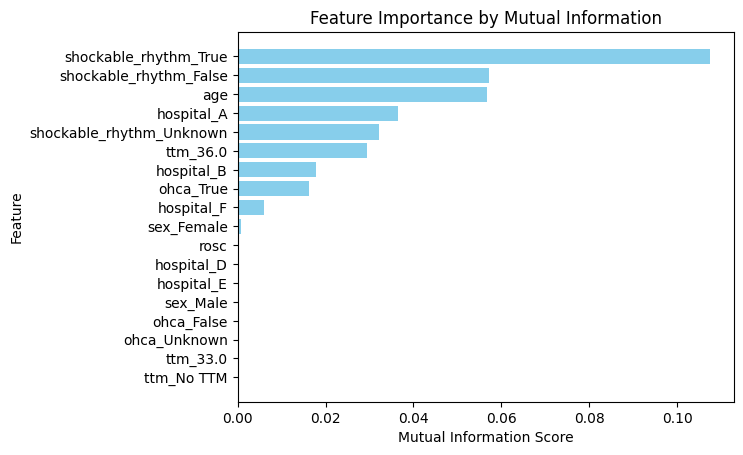

In [34]:
# Getting the feature names 
feature_names = data_encoded.columns

# Combining feature scores with their names
feature_scores = list(zip(feature_names, fs.scores_))

# Sorting the features by score in descending order
feature_scores_sorted = sorted(feature_scores, key=lambda x: x[1], reverse=True)

for feature, score in feature_scores_sorted:
    print(f"Feature: {feature}, Score: {score:.6f}")

# Plotting the features
features_names = [feature for feature, score in feature_scores_sorted]
features_scores = [score for feature, score in feature_scores_sorted]

plt.barh(features_names, features_scores, color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Feature Importance by Mutual Information')
plt.gca().invert_yaxis()  # To have the highest score at the top
plt.show()

## Feature Selection by Random Forest

Accuracy: 0.6517412935323383
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       126
           1       0.54      0.43      0.48        75

    accuracy                           0.65       201
   macro avg       0.62      0.61      0.61       201
weighted avg       0.64      0.65      0.64       201

Feature: age, Score: 0.439036
Feature: rosc, Score: 0.159681
Feature: shockable_rhythm_False, Score: 0.089640
Feature: shockable_rhythm_True, Score: 0.082729
Feature: sex_Female, Score: 0.024251
Feature: ohca_False, Score: 0.022465
Feature: sex_Male, Score: 0.021771
Feature: ohca_True, Score: 0.019365
Feature: hospital_B, Score: 0.018945
Feature: hospital_A, Score: 0.017951
Feature: ttm_33.0, Score: 0.017843
Feature: ttm_36.0, Score: 0.015987
Feature: hospital_F, Score: 0.015673
Feature: hospital_D, Score: 0.014670
Feature: hospital_E, Score: 0.012746
Feature: ttm_No TTM, Score: 0.010971
Feature: ohca_Unknown, Score: 0.010100
Feature: s

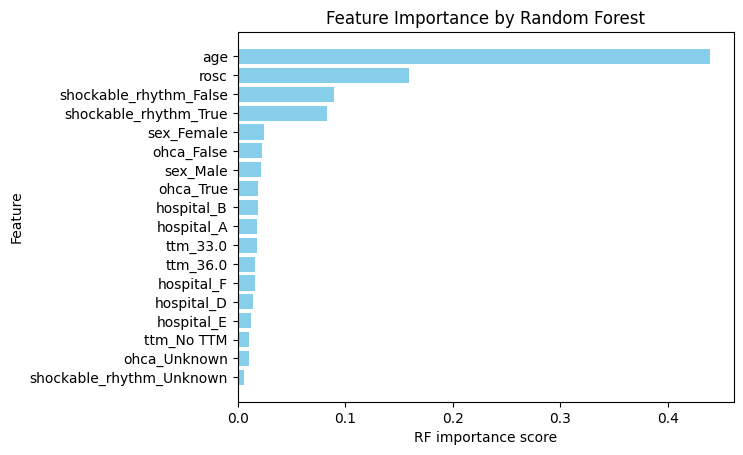

In [35]:
# Random Forest feature importance 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Initialize and train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_

# Getting the feature names (if df_encoded_complete is a DataFrame, it has column names)
feature_names = data_encoded.columns

# Combining feature scores with their names
importance_scores = list(zip(feature_names, importances))

# Sorting the features by score in descending order
importance_scores_sorted = sorted(importance_scores, key=lambda x: x[1], reverse=True)

for feature, score in importance_scores_sorted:
    print(f"Feature: {feature}, Score: {score:.6f}")

# Plotting the features
features_names = [feature for feature, score in importance_scores_sorted]
features_scores = [score for feature, score in importance_scores_sorted]

plt.barh(features_names, features_scores, color='skyblue')
plt.xlabel('RF importance score')
plt.ylabel('Feature')
plt.title('Feature Importance by Random Forest')
plt.gca().invert_yaxis()  # To have the highest score at the top
plt.show()



## Feature Selection by Permutation

Feature: 0, Score: 0.14201
Feature: 1, Score: 0.07578
Feature: 2, Score: 0.01450
Feature: 3, Score: 0.01450
Feature: 4, Score: 0.01087
Feature: 5, Score: 0.00758
Feature: 6, Score: 0.00428
Feature: 7, Score: 0.01483
Feature: 8, Score: 0.02076
Feature: 9, Score: 0.00494
Feature: 10, Score: 0.00329
Feature: 11, Score: 0.00395
Feature: 12, Score: 0.01054
Feature: 13, Score: 0.01483
Feature: 14, Score: 0.00791
Feature: 15, Score: 0.05140
Feature: 16, Score: 0.05140
Feature: 17, Score: -0.00066
Feature: age, Score: 0.142010
Feature: rosc, Score: 0.075783
Feature: shockable_rhythm_True, Score: 0.051400
Feature: shockable_rhythm_False, Score: 0.051400
Feature: sex_Male, Score: 0.020758
Feature: ttm_36.0, Score: 0.014827
Feature: sex_Female, Score: 0.014827
Feature: hospital_A, Score: 0.014498
Feature: hospital_B, Score: 0.014498
Feature: hospital_D, Score: 0.010873
Feature: ttm_33.0, Score: 0.010544
Feature: ttm_No TTM, Score: 0.007908
Feature: hospital_E, Score: 0.007578
Feature: ohca_False,

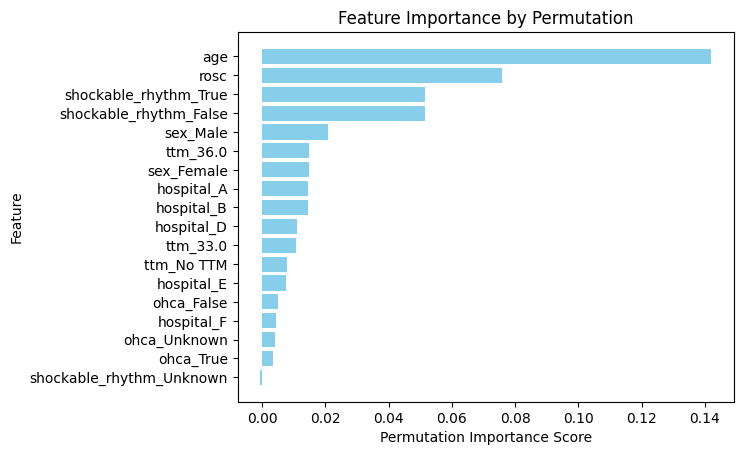

In [36]:
# Permutation feature importance

from sklearn.inspection import permutation_importance
# perform permutation importance
results = permutation_importance(rf, X, y, scoring='accuracy')

# get importance
perm_importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(perm_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
      
# Combining feature scores with their names
perm_importance_scores = list(zip(feature_names, perm_importance))

# Sorting the features by score in descending order
perm_importance_scores_sorted = sorted(perm_importance_scores, key=lambda x: x[1], reverse=True)

for feature, score in perm_importance_scores_sorted:
    print(f"Feature: {feature}, Score: {score:.6f}")

# Plotting the features
features_names = [feature for feature, score in perm_importance_scores_sorted]
perm_features_scores = [score for feature, score in perm_importance_scores_sorted]

plt.barh(features_names, perm_features_scores, color='skyblue')
plt.xlabel('Permutation Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance by Permutation')
plt.gca().invert_yaxis()  # To have the highest score at the top
plt.show()
